In [1]:
import numpy as np
import pandas as pd
import math

df = pd.read_csv("filtered_protacs.csv")
f = open("dc50_labels.txt", "r")
lines = f.readlines()
refined_lines = []
for l in lines:
    l = l.replace("(n/a)", "")
    l = l.replace("\n", "")
    l = l.replace(">", "")
    l = l.replace("<", "")
    l = l.replace("=", "")
    refined_lines.append(l)

final_labels = []
for l in refined_lines:
    arr = l.split('/')
    if len(arr) > 1:
        smallest_so_far = 999999
        for el in arr:
            if el == "":
                continue
            if el.find("~") > 0 or el.find("-") > 0:
                continue
            el = float(el)
            if el < smallest_so_far:
                smallest_so_far = el
        final_labels.append(smallest_so_far)
    else:
        final_labels.append(arr[0])

target_proteins = np.array(list(df["Target Protein"]))
e3_targets = np.array(list(df["E3 Target"]))
warheads = np.array(list(df["Warhead"]))
linkers = np.array(list(df["Linker"]))
e3_ligands = np.array(list(df["E3 Ligand"]))

labeled_indices = []
for i, val in enumerate(final_labels):
    val = str (val)
    if val == "":
        continue
    else:
        labeled_indices.append(i)
        
target_proteins = target_proteins[labeled_indices]
e3_targets = e3_targets[labeled_indices]
warheads = warheads[labeled_indices]
linkers = linkers[labeled_indices]
e3_ligands = e3_ligands[labeled_indices]
final_labels = np.array(final_labels)
my_labels = final_labels[labeled_indices]

print(len(target_proteins))
print(len(e3_targets))
print(len(warheads))
print(len(linkers))
print(len(e3_ligands))
print(len(my_labels))

903
903
903
903
903
903


In [2]:
from tqdm import tqdm as tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
from sklearn.preprocessing import normalize
from itertools import product

def sequence_to_kmer(protein_seq, k):
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range(0, len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range(0, len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct, ind))
    
    V=np.zeros(int((math.pow(7,k))))
    try:
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]] += 1
    except:
        count={'1':0,'2':0,'3':0, '4':0, '5':0,'6':0,'7':0}
        for q in range(0,len(protein_seq)):
            if protein_seq[q]=='A' or protein_seq[q]=='V' or protein_seq[q]=='G':
                count['1']+=1
            if protein_seq[q]=='I' or protein_seq[q]=='L'or protein_seq[q]=='F' or protein_seq[q]=='P':
                count['2']+=1
            if protein_seq[q]=='Y' or protein_seq[q]=='M'or protein_seq[q]=='T' or protein_seq[q]=='S':
                count['3']+=1
            if protein_seq[q]=='H' or protein_seq[q]=='N'or protein_seq[q]=='Q' or protein_seq[q]=='W':
                count['4']+=1
            if protein_seq[q]=='R' or protein_seq[q]=='K':
                count['5']+=1
            if protein_seq[q]=='D' or protein_seq[q]=='E':
                count['6']+=1
            if protein_seq[q]=='C':
                count['7']+=1
        
        value=list(count.values())
        key=list(count.keys())
        maximum_occurence=0
        index=0
        for t in range(0, len(value)):
            if maximum_occurence < value[t]:
                maximum_occurence = value[t]
                index=t
        maximum_occurence = key[index] # group number of maximum occuring group
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                if kmer[l] not in groups:
                    c += maximum_occurence
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]] += 1
            
        V = V/(len(protein_seq)-1)
        return np.array(V)
    

def get_protein_features(protein_sequence):
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f = []
    protein_info = ProteinAnalysis(str(protein_sequence))
    protein_info.molecular_weight()
    amino_acid_percent = protein_info.get_amino_acids_percent()
    dp = []
    for a in aa:
        dp.append(amino_acid_percent[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])
    twomer=np.array(sequence_to_kmer(str(protein_sequence), 2))
    twomer=normalize(np.atleast_2d(twomer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(twomer[0])
    threemer=np.array(sequence_to_kmer(str(protein_sequence), 3))
    threemer=normalize(np.atleast_2d(threemer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(threemer[0])
    return np.array(f)

In [3]:
labels = []
for m in my_labels:
    if m.find("~") > 0:
        m.split("~")
        m = float (m[0])
        labels.append(m)
    elif m.find("-") > 0:
        m.split("-")
        m = float (m[0])
        labels.append(m)
    else:
        m = float (m)
        labels.append(m)

target_protein_features = []
e3_target_features = []

for i in tqdm(range(len(target_proteins))):
    p = get_protein_features(target_proteins[i])
    et = get_protein_features(e3_targets[i])
    
    target_protein_features.append(p)
    e3_target_features.append(et)
    
target_protein_features = np.array(target_protein_features)
e3_target_features = np.array(e3_target_features)    

100%|███████████████████████████████████████████████████████████████████████████████| 903/903 [00:06<00:00, 141.37it/s]


In [4]:
import datamol as dm
from molfeat.calc import FPCalculator 
from molfeat.trans import MoleculeTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer
from molfeat.trans.pretrained import PretrainedDGLTransformer
from molfeat.trans.pretrained import GraphormerTransformer
from molfeat.trans.pretrained.dgl_pretrained import DGLModel
from molfeat.store.modelstore import ModelStore

calc = FPCalculator("secfp")

transformer = MoleculeTransformer(calc, n_jobs=0)
warhead_features = np.array(transformer(warheads))
linker_features = np.array(transformer(linkers))
e3_ligand_features = np.array(transformer(e3_ligands))

print(warhead_features.shape)
print(linker_features.shape)
print(e3_ligand_features.shape)

Your OS does not support multiprocessing based on fork, please use num_workers=0


(903, 2048)
(903, 2048)
(903, 2048)


In [5]:
dataset = np.column_stack((target_protein_features, e3_target_features,
                          warhead_features, e3_ligand_features, linker_features))

print(dataset.shape)
print(dataset[0])
labels = np.array(labels)
labels = np.log(labels)
print(labels.shape)

(903, 6968)
[0.32110047 0.10237986 0.32110047 ... 0.         0.         0.        ]
(903,)


(903, 2)


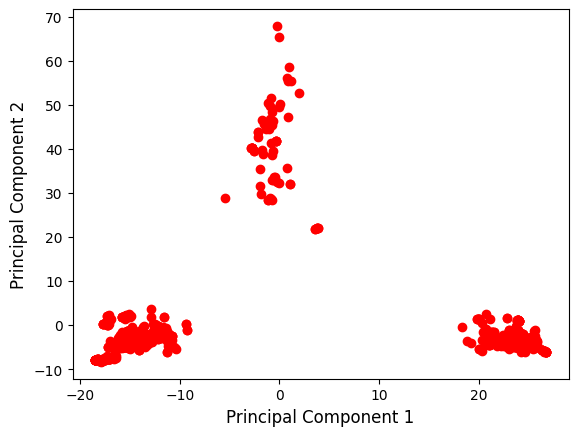

In [6]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# standardise data
scaler = StandardScaler(with_mean=True, with_std=True)
standardised_dataset = scaler.fit_transform(dataset)

# PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(standardised_dataset)
print(X_reduced.shape)

plt.scatter(X_reduced[:,0], X_reduced[:,1], color="r", label="data")
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.show()

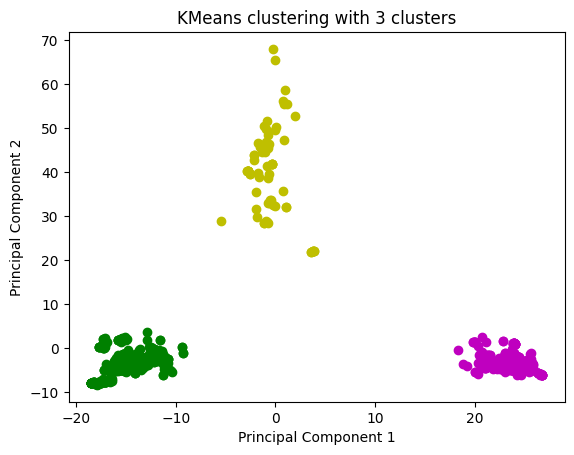

6968


In [7]:
from sklearn.cluster import KMeans

# MIX DATA FROM EACH CLUSTER TO CREATE EACH FOLD

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_reduced)

cluster_0_indices = []
cluster_1_indices = []
cluster_2_indices = []

for i, k in enumerate(kmeans.labels_):
    if k == 0:
        cluster_0_indices.append(i)
    elif k == 1:
        cluster_1_indices.append(i)
    else:
        cluster_2_indices.append(i)

X_0 = X_reduced[cluster_0_indices]
X_1 = X_reduced[cluster_1_indices]
X_2 = X_reduced[cluster_2_indices]

plt.scatter(X_0[:,0], X_0[:,1], color='m', label="cluster 1")
plt.scatter(X_1[:,0], X_1[:,1], color='g', label="cluster 2")
plt.scatter(X_2[:,0], X_2[:,1], color='y', label="cluster 3")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans clustering with 3 clusters")
plt.show()

data_0 = []
for i in cluster_0_indices:
    ex = [dataset[i], labels[i]]
    data_0.append(ex)
    
data_1 = []
for i in cluster_1_indices:
    ex = [dataset[i], labels[i]]
    data_1.append(ex)
    
data_2 = []
for i in cluster_2_indices:
    ex = [dataset[i], labels[i]]
    data_2.append(ex)

print(len(data_2[0][0]))

cluster_0_counter = 0
cluster_1_counter = 0
cluster_2_counter = 0
fold_0 = []
fold_1 = []
fold_2 = []
fold_0_labels = []
fold_1_labels = []
fold_2_labels = []

i = 0
while i < len(data_0):
    fold_0.append([data_0[i][0], data_0[i][1]])
    i += 1
    if i >= len(data_0):
        break
    fold_1.append([data_0[i][0], data_0[i][1]])
    i += 1
    if i >= len(data_0):
        break
    fold_2.append([data_0[i][0], data_0[i][1]])
    i += 1
    
i = 0
while i < len(data_1):
    fold_0.append([data_1[i][0], data_1[i][1]])
    i += 1
    if i >= len(data_1):
        break
    fold_1.append([data_1[i][0], data_1[i][1]])
    i += 1
    if i >= len(data_1):
        break
    fold_2.append([data_1[i][0], data_1[i][1]])
    i += 1
    
i = 0
while i < len(data_2):
    fold_0.append([data_2[i][0], data_2[i][1]])
    i += 1
    if i >= len(data_2):
        break
    fold_1.append([data_2[i][0], data_2[i][1]])
    i += 1
    if i >= len(data_2):
        break
    fold_2.append([data_2[i][0], data_2[i][1]])
    i += 1


232 components explains more than 95% of the data variance


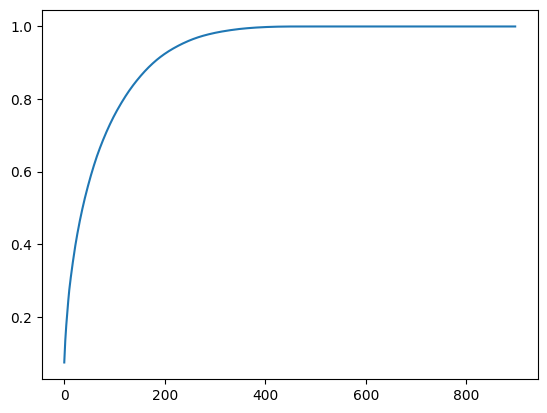

In [8]:
# Scree graph of PCA
scree_pca = PCA(n_components=898).fit(standardised_dataset)
cumulative_explained_variance = np.cumsum(scree_pca.explained_variance_ratio_)
for i, c in enumerate(cumulative_explained_variance):
    if c > 0.95:
        print(i, "components explains more than 95% of the data variance")
        no_of_features = i
        break
plt.plot(cumulative_explained_variance)



rmse: 1.5812060882256127    r2: 0.6947849783831044    spearman: 0.7969189910930637    pearson: 0.8350184463728875


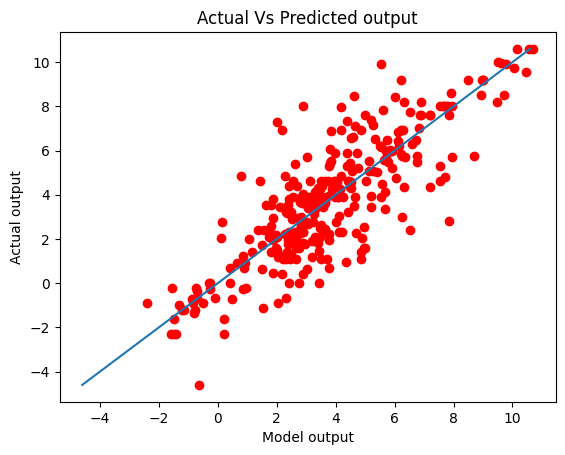

rmse: 1.5681647366542657    r2: 0.6990918000424078    spearman: 0.8069790841314716    pearson: 0.8369485860469303


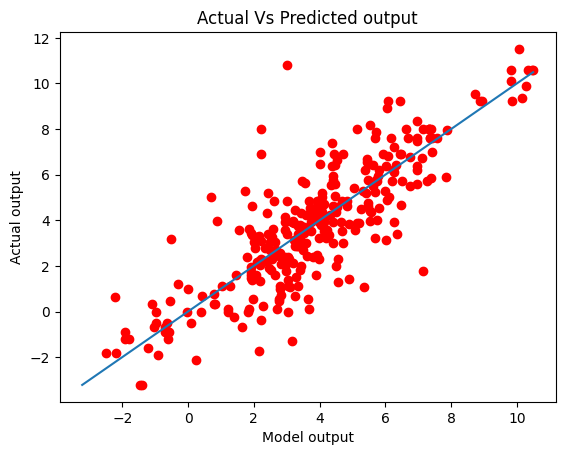

rmse: 1.6715805882895116    r2: 0.687908747473863    spearman: 0.7980237685056725    pearson: 0.8296304716804243


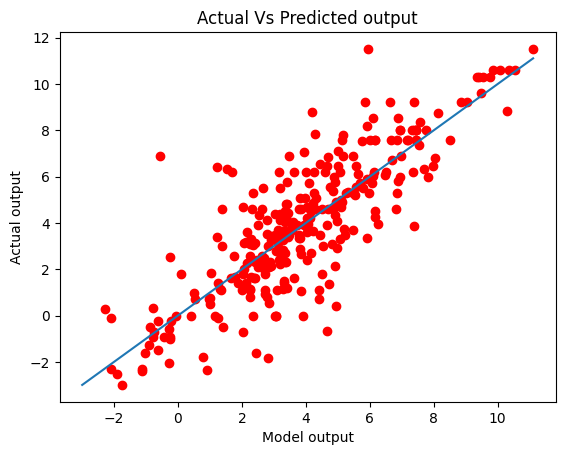



******Performance of XGBoost using SECFP******
root mean square error:  1.6069838043897968
pearson correlation coefficient:  0.8338658347000808
spearman correlation coefficient:  0.8006406145767359
r2 score:  0.693928508633125


In [9]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

rmse_scores = []
r2_scores = []
spearman_scores = []
pearson_scores = []

for i in range(3):
    if i == 0:
        train_dataset = fold_0 + fold_1
        val_dataset = fold_2
    elif i == 1:
        train_dataset = fold_0 + fold_2
        val_dataset = fold_1
    else:
        train_dataset = fold_1 + fold_2
        val_dataset = fold_0
    
    examples = []
    my_labels = []
    for i in range(len(train_dataset)):
        examples.append(train_dataset[i][0])
        my_labels.append(train_dataset[i][1])
    examples = np.array(examples)
    my_labels = np.array(my_labels)
    
    test_examples = []
    test_labels = []
    for i in range(len(val_dataset)):
        test_examples.append(val_dataset[i][0])
        test_labels.append(val_dataset[i][1])
    test_examples = np.array(test_examples)
    answers = np.array(test_labels)
    
    model.fit(examples, my_labels)
    outputs = model.predict(test_examples)
    coeffr, _ = pearsonr(answers, outputs)
    coeffs, _ = spearmanr(answers, outputs)
    rmse = math.sqrt(mean_squared_error(answers, outputs))
    r2 = r2_score(answers, outputs)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    spearman_scores.append(coeffs)
    pearson_scores.append(coeffr)
    print("rmse:", rmse, "  ", "r2:", r2, "  ", "spearman:", coeffs, "  ", "pearson:", coeffr)
    plt.scatter(outputs, answers, color='r')
    if min(outputs) < min(answers):
        minimum = min(outputs)
    else:
        minimum = min(answers)
    
    if max(outputs) < max(answers):
        maximum = max(outputs)
    else:
        maximum = max(answers)
    y = np.linspace(minimum, maximum)
    x = y
    plt.plot(x, y) # plot line y=x
    plt.xlabel("Model output")
    plt.ylabel("Actual output")
    plt.title("Actual Vs Predicted output")
    plt.show()
    
print()
print()
print("******Performance of XGBoost using SECFP******") 
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())

In [20]:
# TEST the model
test_df = pd.read_csv("test_protac_dataset.csv")

test_names = test_df["Name"]
test_target_proteins = test_df["Protein AA"]
test_e3_targets = test_df["E3 ligase AA"]
test_warheads = test_df["Warhead"]
test_linkers = test_df["Linker"]
test_e3_ligands = test_df["E3 ligand"]
true_values = test_df["DC50 (log)"]


test_target_protein_features = []
test_e3_target_features = []

for i in tqdm(range(len(test_target_proteins))):
    p = get_protein_features(test_target_proteins[i])
    et = get_protein_features(test_e3_targets[i])
    
    test_target_protein_features.append(p)
    test_e3_target_features.append(et)
    
test_target_protein_features = np.array(test_target_protein_features)
test_e3_target_features = np.array(test_e3_target_features)  

print(test_target_protein_features.shape)
print(test_e3_target_features.shape)

test_warhead_features = np.array(transformer(test_warheads))
test_linker_features = np.array(transformer(test_linkers))
test_e3_ligand_features = np.array(transformer(test_e3_ligands))

test_dataset = np.column_stack((test_target_protein_features, test_e3_target_features,
                          test_warhead_features, test_e3_ligand_features, test_linker_features))

test_results = model.predict(test_dataset)
results_dict = {}
for i, name in enumerate(test_names):
    results_dict[name] = test_results[i]
    
for k, val, l in zip(results_dict.keys(), results_dict.values(), true_values):
    print(k, "  ",val, "  ", l)
    
test_predictions = np.array(test_results)
true_values = np.array(true_values)

print(len(true_values))
print(len(test_predictions))

coeffr, _ = pearsonr(true_values, test_predictions)
r2 = r2_score(true_values, test_predictions)

print("pearson coefficient on test set: ", coeffr)
print("r2 score on test set: ", r2)

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.37it/s]


(5, 412)
(5, 412)
A1874    3.6770117    1.505149978
ARV-110    4.912283    0.0
ARV-471    1.8248944    0.301029996
ARV-771    3.4157906    0.698970004
ARV-825    0.9381351    0.0
5
5
pearson coefficient on test set:  0.27012669573116604
r2 score on test set:  -23.807108366413583
